## Data Preprocessing

In [20]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_poisson_deviance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

conn = sqlite3.connect(r'C:\Users\Owner\dev\algobetting\infra\data\db\algobetting.db')

df = pd.read_sql_query("""
                        SELECT DISTINCT
                            f.*,
                            ms.shots,
                            ms.opp_shots
                        FROM 
                            fbref_team_goals_features_005_365 f
                        JOIN
                            fbref_match_summary ms
                                ON ms.match_url = f.match_url
                                AND ms.team = f.team
                        WHERE 
                            f.match_date > '2021-11-01'
                       """, conn)

df

,match_url,match_date,season,division,team,opp_team,is_home,goals,opp_goals,xg,...,opp_weighted_defense_opp_shots_on_target,opp_weighted_defense_opp_xg,opp_weighted_defense_opp_npxg,opp_weighted_defense_opp_touches_att_pen_area,opp_weighted_defense_opp_touches_att_3rd,opp_weighted_defense_opp_touches,opp_weighted_defense_opp_pens_won,opp_weighted_defense_opp_corner_kicks,shots,opp_shots
0,https://fbref.com/en/matches/d8efb6cc/Leiceste...,2025-04-07 00:00:00,2024-2025,Premier-League,Leicester City,Newcastle Utd,1,0,3,0.5,...,4.355476,1.303009,1.251797,24.197442,155.426749,602.362132,0.065146,4.995137,7.0,16.0
1,https://fbref.com/en/matches/d8efb6cc/Leiceste...,2025-04-07 00:00:00,2024-2025,Premier-League,Newcastle Utd,Leicester City,0,3,0,3.3,...,5.494694,1.887059,1.825313,31.816265,195.700380,690.196090,0.073388,6.049093,16.0,7.0
2,https://fbref.com/en/matches/53e359bb/Manchest...,2025-04-06 00:00:00,2024-2025,Premier-League,Manchester Utd,Manchester City,1,0,0,0.9,...,3.624739,1.283831,1.218377,18.396063,101.868168,517.512371,0.081817,3.457143,13.0,9.0
3,https://fbref.com/en/matches/53e359bb/Manchest...,2025-04-06 00:00:00,2024-2025,Premier-League,Manchester City,Manchester Utd,0,0,0,0.5,...,4.125325,1.549812,1.440821,22.861867,150.093587,588.030979,0.103199,5.190624,9.0,13.0
4,https://fbref.com/en/matches/f671e515/Tottenha...,2025-04-06 00:00:00,2024-2025,Premier-League,Tottenham,Southampton,1,3,1,2.1,...,6.432989,2.281046,2.105396,32.140872,176.702024,626.645503,0.143379,5.438184,12.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,https://fbref.com/en/matches/3537bd55/Celta-Vi...,2025-05-10 00:00:00,2024-2025,La-Liga,Sevilla,Celta Vigo,0,2,3,2.3,...,3.562417,1.135448,1.026313,18.241637,127.491568,598.672673,0.100880,4.139149,18.0,8.0
12902,https://fbref.com/en/matches/ed775615/Valencia...,2025-05-10 00:00:00,2024-2025,La-Liga,Valencia,Getafe,1,3,0,2.7,...,3.140696,1.272427,1.108446,17.558451,115.609838,594.839955,0.175962,4.067525,8.0,10.0
12903,https://fbref.com/en/matches/ed775615/Valencia...,2025-05-10 00:00:00,2024-2025,La-Liga,Getafe,Valencia,0,0,3,0.5,...,3.899444,1.344925,1.193799,20.162915,148.126348,624.160701,0.152573,5.009976,10.0,8.0
12904,https://fbref.com/en/matches/ce67853a/Las-Palm...,2025-05-09 00:00:00,2024-2025,La-Liga,Las Palmas,Rayo Vallecano,1,0,1,0.7,...,3.975350,1.405973,1.224663,20.504361,128.134520,559.365555,0.236948,4.831992,11.0,16.0


## Exploratory Data Analysis

Text(0.5, 1.0, 'Actual vs Theoretical Poisson')

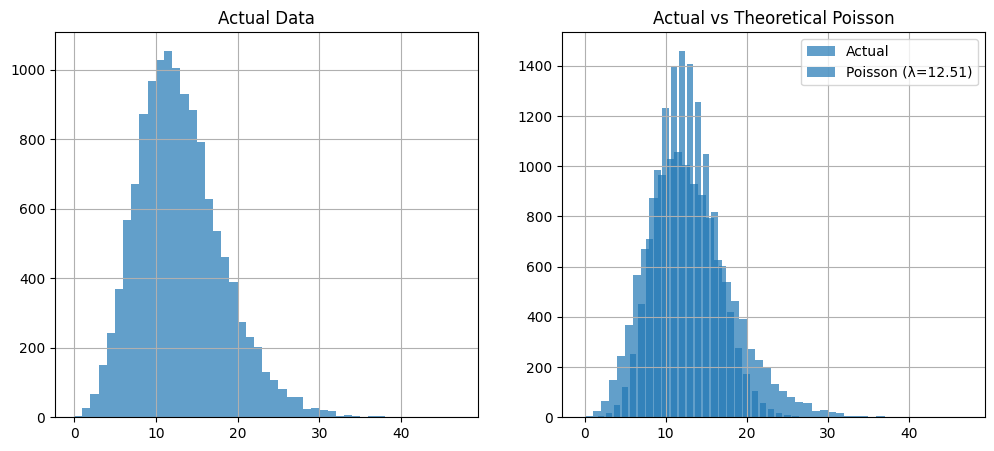

In [21]:
from scipy import stats

# Calculate sample mean (which estimates lambda for Poisson)
lambda_est = df["shots"].mean()
df["shots"] = df["shots"].astype(int)

# Create theoretical Poisson distribution
x_range = range(0, df["shots"].max() + 1)
poisson_pmf = stats.poisson.pmf(x_range, lambda_est)
poisson_expected = poisson_pmf * len(df)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Your actual data
df["shots"].hist(bins=range(0, df["shots"].max() + 2), ax=ax1, alpha=0.7)
ax1.set_title("Actual Data")

# Overlay theoretical on actual
df["shots"].hist(bins=range(0, df["shots"].max() + 2), alpha=0.7, label="Actual")
plt.bar(x_range, poisson_expected, alpha=0.7, label=f"Poisson (λ={lambda_est:.2f})")
plt.legend()
plt.title("Actual vs Theoretical Poisson")

In [22]:
from scipy.stats import kstest

# KS test for Poisson distribution
def poisson_cdf(x):
    return stats.poisson.cdf(x, lambda_est)

ks_stat, ks_p_value = kstest(df["shots"], poisson_cdf)
print(f"KS test: statistic={ks_stat:.3f}, p-value={ks_p_value:.3f}")

print(f"Sample size: {len(df)}")
print(f"Mean: {df['shots'].mean():.2f}")
print(f"Variance: {df['shots'].var():.2f}")
print(f"Variance/Mean ratio: {df['shots'].var()/df['shots'].mean():.3f}")

KS test: statistic=0.122, p-value=0.000
Sample size: 12906
Mean: 12.51
Variance: 27.64
Variance/Mean ratio: 2.209


Negative binomial parameters: n=10.35, p=0.453
Negative Binomial KS test: statistic=0.081, p-value=0.000


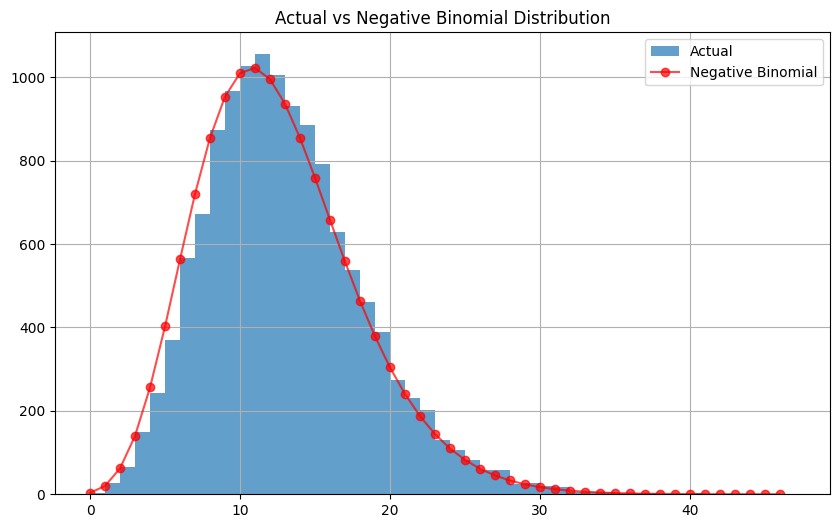

In [23]:
from scipy.stats import nbinom
import numpy as np

# Fit negative binomial distribution
# Method of moments estimators
mean = df["shots"].mean()
var = df["shots"].var()

# Calculate parameters
p = mean / var
n = mean**2 / (var - mean)

print(f"Negative binomial parameters: n={n:.2f}, p={p:.3f}")

# Test fit
def nb_cdf(x):
    return nbinom.cdf(x, n, p)

ks_stat_nb, ks_p_nb = kstest(df["shots"], nb_cdf)
print(f"Negative Binomial KS test: statistic={ks_stat_nb:.3f}, p-value={ks_p_nb:.3f}")

# Visual comparison
x_range = range(0, df["shots"].max() + 1)
nb_pmf = nbinom.pmf(x_range, n, p) * len(df)

plt.figure(figsize=(10, 6))
df["shots"].hist(bins=range(0, df["shots"].max() + 2), alpha=0.7, label="Actual")
plt.plot(x_range, nb_pmf, 'ro-', alpha=0.7, label=f"Negative Binomial")
plt.legend()
plt.title("Actual vs Negative Binomial Distribution")
plt.show()

## Feature Engineering

In [24]:
def add_features(X, df):
    # Original gap metrics code
    attack_features = [col for col in X.columns if col.startswith('weighted_attack_')]
    defense_features = [col for col in X.columns if col.startswith('opp_weighted_defense_')]
    
    feature_pairs = []
    for attack_feature in attack_features:
        metric = attack_feature.replace('weighted_attack_', '')
        defense_feature = f'opp_weighted_defense_opp_{metric}'
        
        if defense_feature in defense_features:
            feature_pairs.append((attack_feature, defense_feature, metric))
    
    for attack_feature, defense_feature, metric in feature_pairs:
        # Gap metrics
        gap_feature_name = f'{metric}_gap'
        X[gap_feature_name] = X[attack_feature] - X[defense_feature]
        
        # Ratio metrics
        ratio_feature_name = f'{metric}_ratio'
        X[ratio_feature_name] = X[attack_feature] / X[defense_feature].replace(0, 0.001)
        X[ratio_feature_name] = X[ratio_feature_name].replace([np.inf, -np.inf], np.nan)
        X[ratio_feature_name] = X[ratio_feature_name].fillna(X[ratio_feature_name].mean())
        
        # Interaction terms
        interaction_feature_name = f'{metric}_interaction'
        X[interaction_feature_name] = X[attack_feature] * X[defense_feature]
        
        # Normalized gap
        norm_gap_feature_name = f'{metric}_norm_gap'
        denominator = X[attack_feature] + X[defense_feature]
        X[norm_gap_feature_name] = X[gap_feature_name] / denominator.replace(0, 0.001)
        X[norm_gap_feature_name] = X[norm_gap_feature_name].replace([np.inf, -np.inf], np.nan)
        X[norm_gap_feature_name] = X[norm_gap_feature_name].fillna(X[norm_gap_feature_name].mean())

    
    return X

# Usage:
df = add_features(df.copy(), df)

## Model Training

In [25]:
X = df.drop(columns=["team", "opp_team", "goals", "opp_goals", "match_url",  "match_date", "xg", "opp_xg", "shots", "opp_shots"])
X = pd.get_dummies(X, columns=["season", "division"], drop_first=True)
y = pd.to_numeric(df["shots"], errors='coerce')

X_train = X[df['match_date'] < '2025-01-01']
X_test = X[df['match_date'] >= '2025-01-01']
y_train = y[df['match_date'] < '2025-01-01']
y_test = y[df['match_date'] >= '2025-01-01']

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters for Poisson regression
params = {
    'objective': 'reg:tweedie',
    'tweedie_variance_power': 1.5,  # Between Poisson (1) and Gamma (2)
    'eval_metric': 'tweedie-nloglik@1.5',  # Must specify rho parameter
    'seed': 26
}

# Train the model
num_rounds = 100
model = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=50
)

# Make predictions
y_pred = model.predict(dtest)

# Evaluate model performance
# For Poisson, we can use Poisson deviance and RMSE
poisson_deviance = mean_poisson_deviance(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Poisson Deviance: {poisson_deviance:.4f}")
print(f"RMSE: {rmse:.4f}")

# Calculate mean absolute error for count data
mae = np.mean(np.abs(y_test - np.round(y_pred)))
print(f"MAE (rounded predictions): {mae:.4f}")

# Get feature importance
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importance:")
for feature, score in importance[:10]:
    print(f"{feature}: {score:.2f}")

[0]	train-tweedie-nloglik@1.5:14.75813	test-tweedie-nloglik@1.5:14.49733
[20]	train-tweedie-nloglik@1.5:14.02247	test-tweedie-nloglik@1.5:13.88827
Poisson Deviance: 1.6550
RMSE: 4.5304
MAE (rounded predictions): 3.5118

Feature Importance:
shots_interaction: 51.89
is_home: 24.73
shots_on_target_interaction: 6.02
touches_att_3rd_interaction: 5.63
goals_interaction: 4.54
pens_won_norm_gap: 4.41
touches_att_3rd_gap: 4.16
division_Premier-League: 4.09
division_La-Liga: 4.04
shots_on_target_ratio: 3.88


## Parameter Tuning

In [26]:
import os
import pickle
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_poisson_deviance, mean_squared_error

# File to save best parameters
best_params_file = 'xgb_team_shots_tweedie_params.pkl'  # Updated filename

# Check if we already have saved parameters
if os.path.exists(best_params_file):
    # Load previously found best parameters
    with open(best_params_file, 'rb') as f:
        best_params = pickle.load(f)
    print("Loaded saved Tweedie parameters:")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
        
    # Create model with the best parameters
    best_model = xgb.XGBRegressor(
        objective='reg:tweedie',
        eval_metric=f'tweedie-nloglik@{best_params["tweedie_variance_power"]}',  # Use the tuned value
        random_state=26,
        n_jobs=-1,
        **best_params  # This already includes tweedie_variance_power=1.5
    )
    
    # Train the model on all training data
    best_model.fit(X_train, y_train)
    
else:
    # Run the parameter search if no saved parameters exist
    tuned_model = xgb.XGBRegressor(
        objective='reg:tweedie',
        tweedie_variance_power=1.5,      # Good for overdispersed count data
        eval_metric='tweedie-nloglik@1.5',
        random_state=26,
        n_jobs=-1
    )
    
    # Parameter grid to search (same as before)
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [1, 3, 5, 7],
        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
        'reg_alpha': [0, 0.1, 0.5, 1, 5],
        'reg_lambda': [0.1, 0.5, 1, 5, 10],
        # Optional: also tune the Tweedie variance power
        'tweedie_variance_power': [1.1, 1.2, 1.3, 1.4, 1.5]
    }
    
    # Custom scoring function for Tweedie deviance
    def tweedie_deviance_score(y_true, y_pred, variance_power=1.5):
        """Custom Tweedie deviance scoring function"""
        from sklearn.metrics._regression import _check_reg_targets
        y_true, y_pred = _check_reg_targets(y_true, y_pred, None)
        
        if variance_power == 0:
            # Normal distribution
            dev = np.sum((y_true - y_pred) ** 2)
        elif variance_power == 1:
            # Poisson distribution  
            dev = 2 * np.sum(y_true * np.log(y_true / y_pred) - y_true + y_pred)
        elif variance_power == 2:
            # Gamma distribution
            dev = 2 * np.sum(np.log(y_pred / y_true) + y_true / y_pred - 1)
        else:
            # General Tweedie
            dev = 2 * np.sum(
                (np.maximum(y_true, 0) ** (2 - variance_power)) / ((1 - variance_power) * (2 - variance_power))
                - y_true * (y_pred ** (1 - variance_power)) / (1 - variance_power)
                + (y_pred ** (2 - variance_power)) / (2 - variance_power)
            )
        return -dev  # Negative because sklearn wants higher scores to be better
    
    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=tuned_model,
        param_distributions=param_grid,
        n_iter=500,
        scoring='neg_mean_poisson_deviance',  # Use this as approximation for Tweedie
        cv=[(np.where(df['match_date'] < '2025-01-01')[0], 
             np.where(df['match_date'] >= '2025-01-01')[0])],
        verbose=1,
        random_state=26,
        n_jobs=-1
    )
    
    # Run the random search
    print("Running Tweedie parameter search (this may take a while)...")
    random_search.fit(X, y)
    
    # Get the best parameters and model
    best_params = random_search.best_params_
    best_score = random_search.best_score_
    best_model = random_search.best_estimator_
    
    print(f"Best score: {best_score}")
    print("Best Tweedie parameters:")
    for param, value in best_params.items():
        print(f"    {param}: {value}")
    
    # Save the best parameters for future use
    with open(best_params_file, 'wb') as f:
        pickle.dump(best_params, f)
    print(f"Saved Tweedie parameters to {best_params_file}")

# Continue with model evaluation
y_pred = best_model.predict(X_test)

# Evaluate final model performance
poisson_deviance = mean_poisson_deviance(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = np.mean(np.abs(y_test - np.round(y_pred)))

print(f"\nFinal Tweedie Model Performance:")
print(f"Poisson Deviance: {poisson_deviance:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE (rounded predictions): {mae:.4f}")

# Calculate mean absolute percentage error for count data
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))) * 100
print(f"MAPE: {mape:.2f}%")

# Get feature importance
importance = best_model.get_booster().get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
print("\nFeature Importance:")
for feature, score in importance[:10]:
    print(f"{feature}: {score:.2f}")

Loaded saved Tweedie parameters:
    tweedie_variance_power: 1.5
    subsample: 0.6
    reg_lambda: 1
    reg_alpha: 0
    n_estimators: 100
    min_child_weight: 1
    max_depth: 3
    learning_rate: 0.05
    gamma: 0.1
    colsample_bytree: 0.9

Final Tweedie Model Performance:
Poisson Deviance: 1.6063
RMSE: 4.4660
MAE (rounded predictions): 3.4961
MAPE: 37.78%

Feature Importance:
shots_interaction: 66.36
touches_att_pen_area_interaction: 30.19
touches_att_3rd_interaction: 29.92
is_home: 29.66
shots_on_target_interaction: 25.63
xg_interaction: 21.51
goals_interaction: 12.86
touches_interaction: 11.56
opp_weighted_defense_opp_npxg: 11.45
npxg_interaction: 9.42


## Predictions

In [27]:
# Generate raw predictions on training data
raw_pred_train = best_model.predict(X_train)

# Generate raw predictions on test data
raw_pred_test = best_model.predict(X_test)

# FIXED APPROACH - Don't use test_indices from original df
# Instead, recreate the processed dataframe that matches your model's data

# Step 1: Recreate the same processed dataframe used for your model
df_processed = df.copy()
df_processed = add_features(df_processed, df_processed)

# Step 2: Apply the same transformations (but keep the original columns we need)
# Create X the same way as before, but keep track of the dataframe
X_temp = df_processed.drop(columns=["team", "opp_team", "goals", "opp_goals", "match_url", 
                                   "match_date", "xg", "opp_xg", "shots", "opp_shots"])
X_temp = pd.get_dummies(X_temp, columns=["season", "division"], drop_first=True)
y_temp = pd.to_numeric(df_processed["shots"], errors='coerce')

# Step 3: Get the test subset that actually matches your model's test data
test_mask = df_processed['match_date'] >= '2025-01-01'
test_df_aligned = df_processed[test_mask].reset_index(drop=True)

# Step 4: Create predictions dataframe
predictions_df = pd.DataFrame({
    'actual_shots': y_test.values,  # Use .values to avoid index alignment issues
    'predicted_shots': raw_pred_test,
    'prediction_error': raw_pred_test - y_test.values
})

# Step 5: Join with the properly aligned test dataframe
result_df = pd.concat([
    test_df_aligned.reset_index(drop=True),  # Properly processed test data
    predictions_df.reset_index(drop=True)    # Predictions
], axis=1)

# Step 6: Create backtest dataframe
backtest_df = result_df[["match_url", "match_date", "season", "division", "team", "opp_team", "is_home", "predicted_shots", "actual_shots", "prediction_error"]]

backtest_df.to_csv("xgb_team_shots_tweedie_preds.csv", index=False)

In [28]:
division_performance = backtest_df.groupby('division').agg({
    'prediction_error': ['mean', 'std', 'median'],
    'predicted_shots': 'mean',
    'actual_shots': 'mean',
    'match_url': 'count'  # Number of matches
}).round(3)

division_performance.columns = ['Mean_Error', 'Std_Error', 'Median_Error', 
                               'Avg_Predicted', 'Avg_Actual', 'Match_Count']
print(division_performance)

                Mean_Error  Std_Error  Median_Error  Avg_Predicted  \
division                                                             
Bundesliga           0.516      4.405         0.691         13.033   
La-Liga             -0.510      4.714        -0.088         11.318   
Ligue-1             -0.182      4.129         0.250         12.389   
Premier-League       0.633      4.682         1.344         13.146   
Serie-A             -0.167      4.272        -0.036         11.489   

                Avg_Actual  Match_Count  
division                                 
Bundesliga          12.517          290  
La-Liga             11.828          320  
Ligue-1             12.570          284  
Premier-League      12.513          306  
Serie-A             11.656          326  
